In [1]:
import imblearn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier

In [3]:
def oversampled_run_RForest(dataset01, dataset02, oversampling_kernel, show_plot="yes"):

    """
    Runs Random Forest oversampling the dataset
    Prints the FROC curve, the area under the ROC curve and the partial area under the FROC curve
    for FPPI between 0 and 1

    Parameters
    ----------
    dataset01, dataset01: numpy arrays containing features and labels for each dataset
    oversampling_kernel: kernel with parameters defined for each oversampling technique
    show_plot: show the FROC curve "yes" or "no"

    Returns
    -------
    full_probabilities: numpy array of probabilities
    full_auc: float representing the full area under the ROC curve
    partial_auc: float representing the partial area under the FROC curve for FPPI between 0 and 1
    FROC_fpr, FROC_tpr: false positive per image and true positive rate numpy arrays corrected for the FROC curve

    """

    dataset01_data = dataset01[:, :-1]
    dataset01_labels = dataset01[:, -1]
    dataset02_data = dataset02[:, :-1]
    dataset02_labels = dataset02[:, -1]
    
    #builds classifier
    clf_opt_train = RandomForestClassifier(n_estimators=1000, #500
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

    clf_opt_test = RandomForestClassifier(n_estimators=1000, #500
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)
    
    # Trains classifier in DataSet01 and tests in DataSet02
    dataset01_data_resampled, dataset01_labels_resampled = oversampling_kernel.fit_sample(dataset01_data,
                                                                                          dataset01_labels)
    

    # Fit to the data. 
    clf_opt_train.fit(dataset01_data_resampled, dataset01_labels_resampled)
    prob1 = clf_opt_train.predict_proba(dataset02_data)
    prob1 = np.column_stack((prob1, dataset02_labels))
    
    # Trains classifier in DataSet02 and tests in DataSet01
    dataset02_data_resampled, dataset02_labels_resampled = oversampling_kernel.fit_sample(dataset02_data,
                                                                                          dataset02_labels)
    
    

    clf_opt_test.fit(dataset02_data_resampled, dataset02_labels_resampled)

    prob2 = clf_opt_test.predict_proba(dataset01_data)
    prob2 = np.column_stack((prob2, dataset01_labels))


    # Calculate the probabilities taking both tests into account
    full_probabilities = np.concatenate((prob1, prob2), axis=0)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(full_probabilities[:, -1], full_probabilities[:, 1],
                                                                    pos_label=1, drop_intermediate=True)
    full_auc = auc(false_positive_rate, true_positive_rate)

    if "yes" == show_plot:
        partial_auc, FROC_fpr, FROC_tpr = classification.ROC_to_FROC(full_probabilities, false_positive_rate, true_positive_rate,
                                                      full_auc)
    elif "no" == show_plot:
        partial_auc, FROC_fpr, FROC_tpr = classification.ROC_to_FROC(full_probabilities, false_positive_rate, true_positive_rate,
                                                      full_auc, "no")

    return full_probabilities, full_auc, partial_auc, FROC_fpr, FROC_tpr


In [4]:
def run_RForest (dataset01, dataset02):
    """
    Runs Random Forest with the optimized values
    Prints the FROC curve, the area under the ROC curve and the partial area under the FROC curve
    for FPPI between 0 and 1

    Parameters
    ----------
    dataset01, dataset01: numpy arrays containing features and labels for each dataset
    
    
    Returns
    -------
    full_probabilities: numpy array of probabilities
    full_auc: float representing the full area under the ROC curve
    partial_auc: float representing the partial area under the FROC curve for FPPI between 0 and 1
    FROC_fpr, FROC_tpr: false positive per image and true positive rate numpy arrays corrected for the FROC curve
    
    """     


    dataset01_data = dataset01[:, :-1]
    dataset01_labels = dataset01[:, -1]
    dataset02_data = dataset02[:, :-1]
    dataset02_labels = dataset02[:, -1]
    

    clf_opt_train = RandomForestClassifier(n_estimators=1000, #500
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)

    clf_opt_test = RandomForestClassifier(n_estimators=1000, #500
                             max_features='sqrt',
                             min_samples_leaf=50,
                             class_weight='balanced',
                             oob_score=True)
    
 
    clf_opt_train.fit(dataset01_data, dataset01_labels)
    prob1 = clf_opt_train.predict_proba(dataset02_data)
    prob1 = np.column_stack((prob1, dataset02_labels))

    clf_opt_test.fit(dataset02_data, dataset02_labels)

    prob2 = clf_opt_test.predict_proba(dataset01_data)
    prob2 = np.column_stack((prob2, dataset01_labels))

    # Calculate the probabilities taking both tests into account
    full_probabilities = np.concatenate((prob1,prob2),axis=0)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(full_probabilities[:,-1], full_probabilities[:,1], pos_label=1, drop_intermediate=True)
    full_auc = auc(false_positive_rate, true_positive_rate)
    partial_auc, FROC_fpr, FROC_tpr = classification.ROC_to_FROC(full_probabilities, false_positive_rate, true_positive_rate, full_auc)

    return full_probabilities, full_auc, partial_auc, FROC_fpr, FROC_tpr

In [5]:
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = "feature-tables/train-data_1527086478.csv" # no LBP
#filename = "feature-tables/train-data_1527093743.csv" # with LBP
dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.vstack((dataset01_data, dataset02_data))
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3117
Number of regions in dataset 02: 3259


Unbalanced Data Set


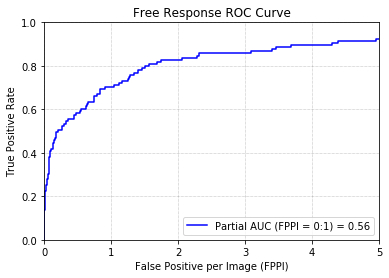

Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56032


In [6]:
set_features = 'all_except_LBP'
#set_features = 'all_with_LBP'
save_results = np.zeros((66,2))
print("Unbalanced Data Set")
_,save_results[0,0],save_results[0,1],_,_ = run_RForest (dataset01, dataset02)

In [7]:
# Testing for Random Over Sampler
print('random_state=0')
_,save_results[1,0],save_results[1,1],_,_ = oversampled_run_RForest (dataset01, dataset02, RandomOverSampler(random_state=0), show_plot = 'no')
print('random_state=None')
_,save_results[2,0],save_results[2,1],_,_ = oversampled_run_RForest (dataset01, dataset02, RandomOverSampler(random_state=None), show_plot = 'no')
print('random_state=10')
_,save_results[3,0],save_results[3,1],_,_ = oversampled_run_RForest (dataset01, dataset02, RandomOverSampler(random_state=10), show_plot = 'no')
print("ratio ='minority', random_state=0")
_,save_results[4,0],save_results[4,1],_,_ = oversampled_run_RForest (dataset01, dataset02, RandomOverSampler(ratio ='minority', random_state=0), show_plot = 'no')
print("ratio ='minority', random_state=None")
_,save_results[5,0],save_results[5,1],_,_ = oversampled_run_RForest (dataset01, dataset02, RandomOverSampler(ratio ='minority', random_state=None), show_plot = 'no')

random_state=0
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56297
random_state=None
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55994
random_state=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56350
ratio ='minority', random_state=0
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56278
ratio ='minority', random_state=None
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55896


In [8]:
# Testing for ADASYN
print('randomstate=None, n_neighbors = 1')
_,save_results[6,0],save_results[6,1],_,_ = oversampled_run_RForest (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 1), show_plot = 'no')
print('randomstate=None, n_neighbors = 5')
_,save_results[7,0],save_results[7,1],_,_ = oversampled_run_RForest (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 5), show_plot = 'no')
print('randomstate=None, n_neighbors = 10')
_,save_results[8,0],save_results[8,1],_,_ = oversampled_run_RForest (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 10), show_plot = 'no')
print('randomstate=None, n_neighbors = 21')
_,save_results[9,0],save_results[9,1],_,_ = oversampled_run_RForest (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 21), show_plot = 'no')

randomstate=None, n_neighbors = 1
Area under the original ROC curve for our classifier: 0.87
Partial area under the FROC curve for FPPI between 0 and 1: 0.42573
randomstate=None, n_neighbors = 5
Area under the original ROC curve for our classifier: 0.86
Partial area under the FROC curve for FPPI between 0 and 1: 0.46112
randomstate=None, n_neighbors = 10
Area under the original ROC curve for our classifier: 0.89
Partial area under the FROC curve for FPPI between 0 and 1: 0.47332
randomstate=None, n_neighbors = 21
Area under the original ROC curve for our classifier: 0.88
Partial area under the FROC curve for FPPI between 0 and 1: 0.48388


In [9]:
#Testing SMOTE with regular algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[10,0],save_results[10,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[11,0],save_results[11,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[12,0],save_results[12,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[13,0],save_results[13,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[14,0],save_results[14,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[15,0],save_results[15,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[16,0],save_results[16,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[17,0],save_results[17,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[18,0],save_results[18,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[19,0],save_results[19,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[20,0],save_results[20,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[21,0],save_results[21,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10), show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56636
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56800
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56867
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55502
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56829
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [10]:
# Testing SMOTE with borderline1 algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[22,0],save_results[22,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[23,0],save_results[23,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[24,0],save_results[24,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[25,0],save_results[25,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[26,0],save_results[26,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[27,0],save_results[27,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[28,0],save_results[28,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[29,0],save_results[29,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[30,0],save_results[30,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[31,0],save_results[31,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[32,0],save_results[32,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[33,0],save_results[33,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline1'), show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.54795
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55726
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55427
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56034
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55992
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [11]:
# Testing SMOTE with borderline2 algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[34,0],save_results[34,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[35,0],save_results[35,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[36,0],save_results[36,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[37,0],save_results[37,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[38,0],save_results[38,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[39,0],save_results[39,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[40,0],save_results[40,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[41,0],save_results[41,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[42,0],save_results[42,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[43,0],save_results[43,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[44,0],save_results[44,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[45,0],save_results[45,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline2'), show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55620
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55321
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55060
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55410
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.56424
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC 

In [12]:
# Testing SMOTE with SVM algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[46,0],save_results[46,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[47,0],save_results[47,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[48,0],save_results[48,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[49,0],save_results[49,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[50,0],save_results[50,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[51,0],save_results[51,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[52,0],save_results[52,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[53,0],save_results[53,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[54,0],save_results[54,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[55,0],save_results[55,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[56,0],save_results[56,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'svm'), show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[57,0],save_results[57,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'svm'), show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55603
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55495
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55782
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55822
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56108
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC 

In [13]:
# Testing SMOTEENN(random_state=42)
print("with SMOTE kind regular")
_,save_results[58,0],save_results[58,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=20)), show_plot = 'no')
print("with SMOTE kind borderline1")
_,save_results[59,0],save_results[59,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=10, kind = 'borderline1')), show_plot = 'no')
print("with SMOTE kind borderline2")
_,save_results[60,0],save_results[60,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=5, m_neighbors=10, kind = 'borderline2')), show_plot = 'no')
print("with SMOTE kind svm")
_,save_results[61,0],save_results[61,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=10, m_neighbors=5, kind = 'svm')), show_plot = 'no')

with SMOTE kind regular
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55688
with SMOTE kind borderline1
Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.54505
with SMOTE kind borderline2
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.54891
with SMOTE kind svm
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56498


In [14]:
# Testing SMOTETomek(random_state=42)
print("with SMOTE kind regular")
_,save_results[62,0],save_results[62,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=20)), show_plot = 'no')
print("with SMOTE kind borderline1")
_,save_results[63,0],save_results[63,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=10, kind = 'borderline1')), show_plot = 'no')
print("with SMOTE kind borderline2")
_,save_results[64,0],save_results[64,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=5, m_neighbors=10, kind = 'borderline2')), show_plot = 'no')
print("with SMOTE kind svm")
_,save_results[65,0],save_results[65,1],_,_ = oversampled_run_RForest (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=10, m_neighbors=5, kind = 'svm')), show_plot = 'no')

with SMOTE kind regular
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.56764
with SMOTE kind borderline1
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.54850
with SMOTE kind borderline2
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.55370
with SMOTE kind svm
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.57256


In [15]:
np.savetxt("RF_notoptimized_noLBP.csv", save_results, delimiter=',')